In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(52)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [7]:
import glob
import pickle

SYNTH_DATA_FILES = glob.glob('../data/simulated/*')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synth_data_1d.pkl
../data/simulated/hawkes_synth_data_2d.pkl
../data/simulated/README.md


In [8]:
process_dim = 1
# Load data simulated using tick
print("Loading {}-dimensional".format(process_dim))
choose_file_index = 0
chosen_file = SYNTH_DATA_FILES[choose_file_index]
print("Data file: {}".format(chosen_file))
with open(SYNTH_DATA_FILES[process_dim-1], "rb") as f:
    loaded_hawkes_data = pickle.load(f)

Loading 1-dimensional
Data file: ../data/simulated/hawkes_synth_data_1d.pkl


In [9]:
print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print(mu)
print(decay)
print(tmax)

times_tensor, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data)

onehot_types = one_hot_embedding(seq_types, process_dim+1)

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
1.0
5.0
60.0


# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= \sigma(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [10]:
from models.decayrnn import HawkesDecayRNN, generate_sequence
from train_functions import train_decayrnn

hidden_size = 24
model = HawkesDecayRNN(process_dim, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.015)

In [11]:
# define training data
train_size = 1000
print("Train size %d" % train_size)

train_times_tensor = times_tensor[:, :train_size]
train_onehot_types = onehot_types[:, :train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_onehot_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 1000
Train event times shape torch.Size([93, 1000])
Train event types shape torch.Size([93, 1000, 2])
Train seq lengths shape torch.Size([1000])


In [12]:
# Training parameters
BATCH_SIZE = 24
EPOCHS = 20

loss_hist = train_decayrnn(model, optimizer, train_times_tensor,
                           train_onehot_types, train_seq_lengths, tmax,
                           BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 24
Number of epochs 20



epoch 1: train loss 41.7913



epoch 2: train loss 11.9212



epoch 3: train loss 2.7106



epoch 4: train loss -2.9848



epoch 5: train loss -7.2115



epoch 6: train loss -10.2951



epoch 7: train loss -12.9709



epoch 8: train loss -15.1705



epoch 9: train loss -16.9217



epoch 10: train loss -18.5013



epoch 11: train loss -20.1483



epoch 12: train loss -21.4443



epoch 13: train loss -22.5774



epoch 14: train loss -23.8621



epoch 15: train loss -24.8759



epoch 16: train loss -25.6475



epoch 17: train loss -26.6268



epoch 18: train loss -27.6368



epoch 19: train loss -28.4218



epoch 20: train loss -29.1824


In [19]:
inp_size = model.input_size
print("Total input size: {}".format(inp_size))

Total input size: 2


In [13]:
from train_functions import plot_loss

In [14]:
model.trained_epochs

20

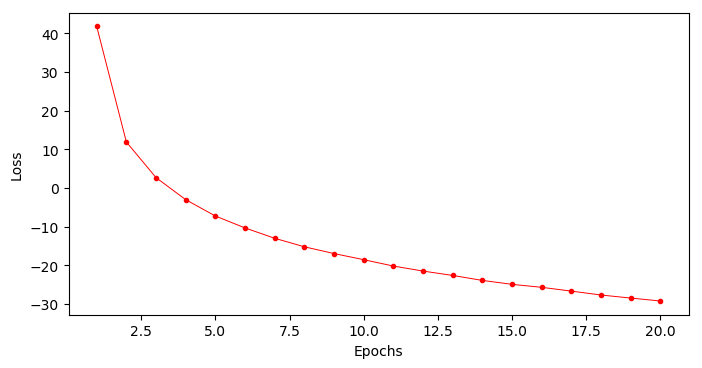

In [15]:
_ = plot_loss(EPOCHS, loss_hist)

## Save to file

In [18]:
import datetime

# Model file dump
SAVED_MODELS_PATH = os.path.abspath('../saved_models')
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
print("Saved models directory: {}".format(SAVED_MODELS_PATH))

date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)
filename_base = "{}-{}-{}".format(model.__class__.__name__, extra_tag, now_timestamp)
filename_model_save = filename_base + ".pth"
filepath = os.path.join(SAVED_MODELS_PATH, filename_model_save)
print("Saving model state dict to {}".format(filepath))
torch.save(model.state_dict(), filepath)

Saved models directory: /home/manifold/Documents/etudes/map511-p3a/saved_models
Saving model state dict to /home/manifold/Documents/etudes/map511-p3a/saved_models/HawkesDecayRNN-1d-20181127-090212.pth


## Model evaluation

Now we perform model evaluation steps.

### Sequence generation and sequence length distribution

#### Load saved model

In [24]:
MODEL_FILES = glob.glob("../saved_models/*.pth")
print(MODEL_FILES)

['../saved_models/HawkesDecayRNN-1d-20181127-143823.pth']


In [25]:
print("Hidden size: {}".format(hidden_size))
model = HawkesDecayRNN(process_dim, hidden_size)

model.load_state_dict(torch.load(MODEL_FILES[0], map_location={"cuda:0": "cpu"}))
model.eval()

Hidden size: 24


HawkesDecayRNN(
  (rnn_layer): RNNCell(2, 24)
  (decay_layer): Sequential(
    (0): Linear(in_features=26, out_features=1, bias=True)
    (1): Softplus(beta=3.0, threshold=20)
  )
  (intensity_layer): Sequential(
    (0): Linear(in_features=24, out_features=2, bias=False)
    (1): Softplus(beta=3.0, threshold=20)
  )
)

In [26]:
# Build a statistic for the no. of events
gen_seq_lengths = []
gen_seq_types_lengths = []
n_gen_seq = 500 # number of generated sequences
for i in range(n_gen_seq):
    (gen_event_times, gen_event_types,
     gen_event_intens, gen_event_decay) = generate_sequence(model, tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)
    gen_seq_types_lengths.append([
        (gen_event_types == i).sum() for i in range(inp_size)
    ])
gen_seq_lengths = np.array(gen_seq_lengths)
gen_seq_types_lengths = np.array(gen_seq_types_lengths)

print("Mean generated sequence length: {}".format(gen_seq_lengths.mean()))
print("Generated sequence length std. dev: {}".format(gen_seq_lengths.std()))
MODEL_NAME = "Decay-RNN"

Mean generated sequence length: 28.582
Generated sequence length std. dev: 6.226337286077586


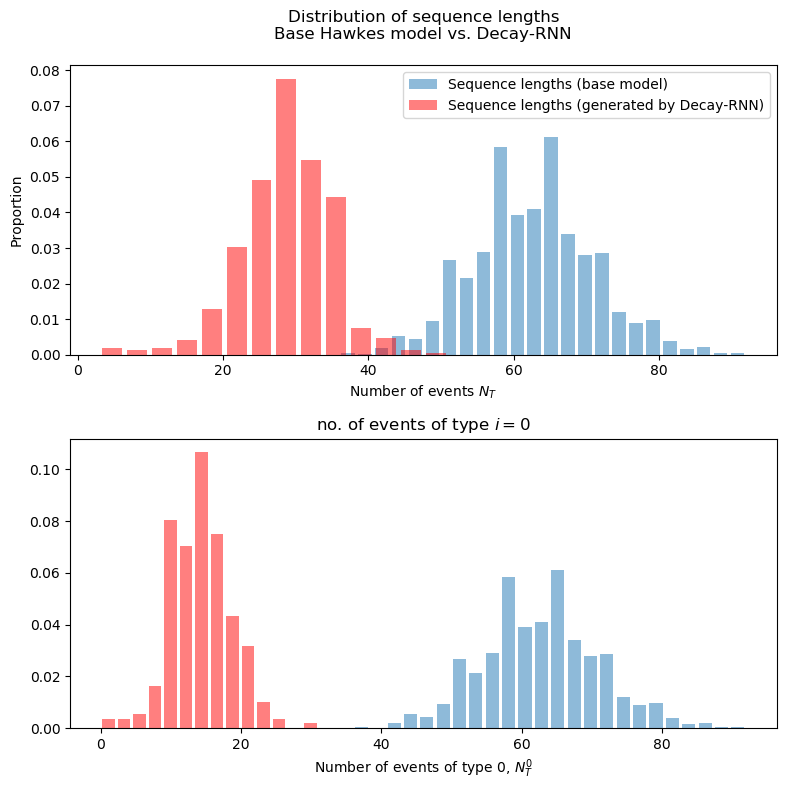

In [27]:
fig, axes = plt.subplots(inp_size, 1, figsize=(8,5+process_dim*3), dpi=100)
ax0 = axes[0]
axt = axes[1:]
_ = ax0.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            rwidth=0.8, alpha=0.5, color='red', density=True)
ax0.legend()
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
ax0.set_title("""Distribution of sequence lengths
Base Hawkes model vs. {:}
""".format(MODEL_NAME))
for i, ax in enumerate(axt):
    # get the sequence lengths for the event types
    typ_seq_lengths = (seq_types == i).sum(dim=0)
    gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
    ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
    ax.hist(gen_typ_seq_lengths,
            bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, color='red', density=True)
    ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
    ax.set_title('no. of events of type $i={}$'.format(i))
fig.tight_layout()

In [96]:
RESULT_BASEDIR = "../results"
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}_{:}-{}.pdf"
            .format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME, extra_tag))

The number of events does not fit.

In [28]:
def plot_events_and_intensity(event_times: torch.Tensor, seq_types: torch.Tensor,
                              hidden_states: torch.Tensor, event_decay: torch.Tensor):
    sequence_length = event_times.shape[0]
    print("no. of events: {}".format(sequence_length))
    evt_times = event_times.numpy()
    evt_types = seq_types.numpy()
    inp_size = model.input_size
    fig, ax = plt.subplots(1, 1, sharex=True, dpi=110,
                                   figsize=(10,1))
    ax.set_ylim((-0.6, 1.6))
    ts_y = np.random.rand(sequence_length)
    inpt_size = model.input_size
    for k in range(inpt_size):
        mask = evt_types == k
        ax.scatter(evt_times[mask], ts_y[mask], s=9,
                   label="{}".format(k), alpha=0.7)
        ax.vlines(evt_times[mask], -0.6, 1.6, linewidth=0.3, linestyles='--', alpha=0.5)
    ax.legend()

no. of events: 28


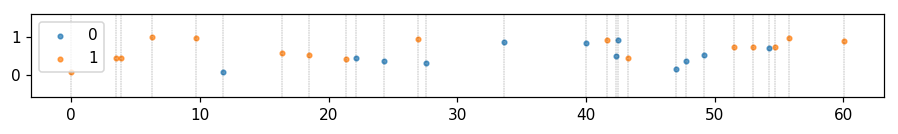

In [29]:
gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)
plot_events_and_intensity(gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay)

In [58]:
from models.decayrnn import read_predict
import torch.nn.functional as F

In [59]:
num_errors = 0

for index in range(500):
    oh_real, oh_pred, type_distrib = read_predict(
        model, times_tensor[:,index],
        onehot_types[:,index], seq_lengths[index])
    num_errors += int(not(oh_real.equal(oh_pred)))